# 1. MIG

## A. MIG 모드 enable

`-` root 획득 

```bash 
sudo -i 
```

`-` 모든 GPU enable 

```bash
nvidia-smi -mig 1 
sudo systemctl stop nvidia-mig-manager.service
sudo systemctl disable nvidia-mig-manager.service
reboot
```

`-` 모든 특정 GPU만 enable

```bash
#nvidia-smi -i {GPUdev-ID} -mig 1
nvidia-smi -i 0 -mig 1 
sudo systemctl stop nvidia-mig-manager.service
sudo systemctl disable nvidia-mig-manager.service
reboot 
```

`-` GPU가 MIG 모드로 되면 아래와 같이 GPU-Util 에 `N/A`로 표시된다. 아래는 0,1,2,4 에 대응하는 GPU가 MIG모드로 설정된 상태임

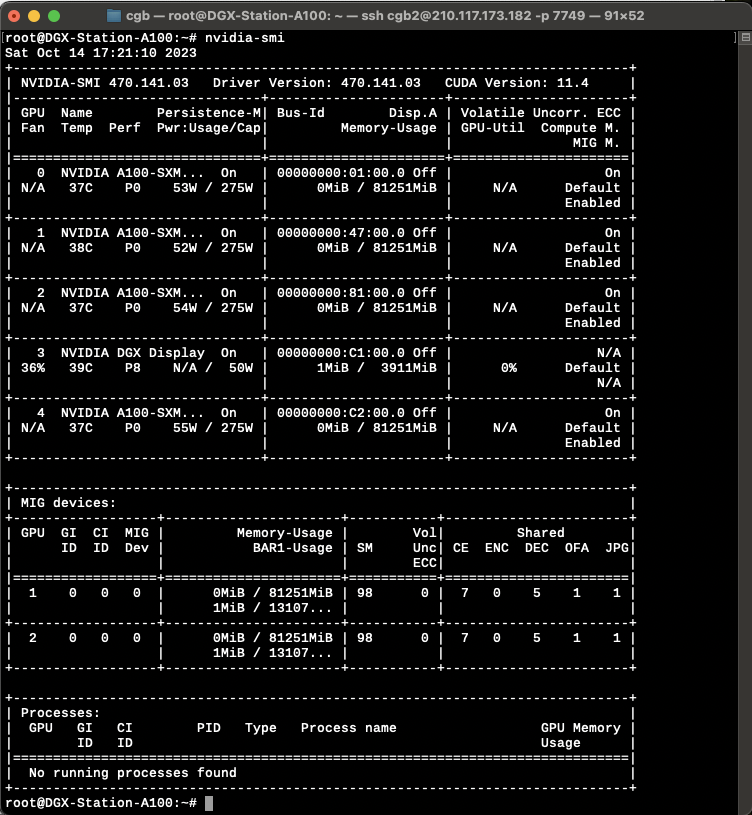

## B. GPU, GI, CI 확인 

`-` 용어정리

- GPU: 말 그대로 GPU
- GI: GPU INSTANCE, 하나의 GPU에 여러개의 GPU INSTANCE가 존재할 수 있음. 
- CI: COMPUTE INSTANCE, 하나의 GPU INSTANCE에 여러개의 COMPUTE INSTANCE를 만들 수 있음. 

`-` 상황확인 

```bash
nvidia-smi 
```

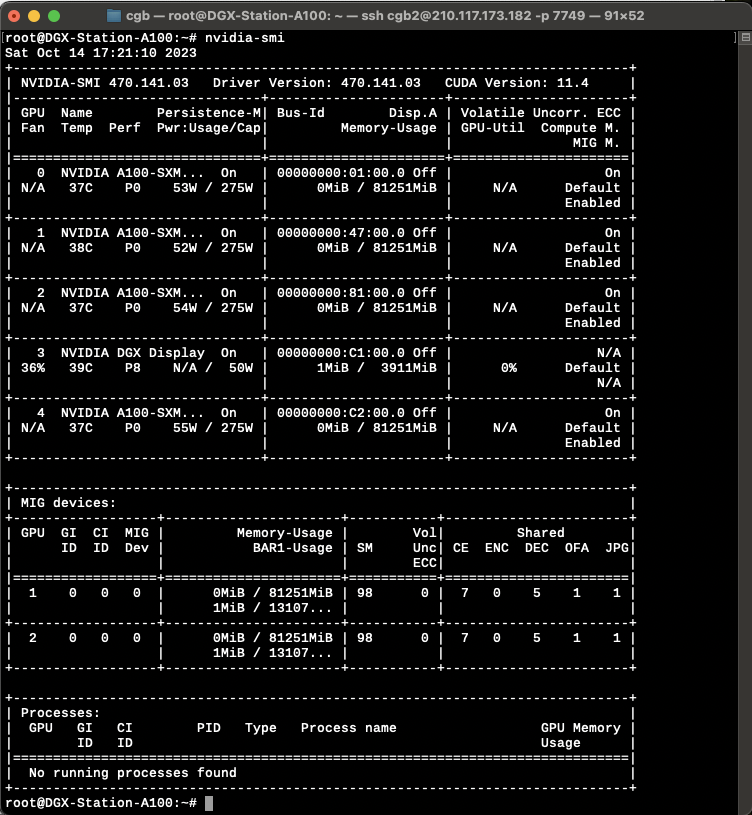

`-` GPU의 해석 

```
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                   On |
| N/A   37C    P0    53W / 275W |      0MiB / 81251MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                   On |
| N/A   38C    P0    52W / 275W |      0MiB / 81251MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   2  NVIDIA A100-SXM...  On   | 00000000:81:00.0 Off |                   On |
| N/A   37C    P0    54W / 275W |      0MiB / 81251MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
|   3  NVIDIA DGX Display  On   | 00000000:C1:00.0 Off |                  N/A |
| 36%   39C    P8    N/A /  50W |      1MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   4  NVIDIA A100-SXM...  On   | 00000000:C2:00.0 Off |                   On |
| N/A   37C    P0    55W / 275W |      0MiB / 81251MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+
```

총 4개의 GPU가 있으며 아이디는 0,1,2,4 임을 알 수 있다. 

`-` `GPUdev-ID`, `GI-ID`, `CI-ID`, `MIGdev-ID` 확인 

```
+-----------------------------------------------------------------------------+
| MIG devices:                                                                |
+------------------+----------------------+-----------+-----------------------+
| GPU  GI  CI  MIG |         Memory-Usage |        Vol|         Shared        |
|      ID  ID  Dev |           BAR1-Usage | SM     Unc| CE  ENC  DEC  OFA  JPG|
|                  |                      |        ECC|                       |
|==================+======================+===========+=======================|
|  1    0   0   0  |      0MiB / 81251MiB | 98      0 |  7   0    5    1    1 |
|                  |      1MiB / 13107... |           |                       |
+------------------+----------------------+-----------+-----------------------+
|  2    0   0   0  |      0MiB / 81251MiB | 98      0 |  7   0    5    1    1 |
|                  |      1MiB / 13107... |           |                       |
+------------------+----------------------+-----------+-----------------------+
```

아래와 같은 상황을 유추할 수 있다. 

| GPUdev ID | GI ID      | CI ID      | MIGdev ID |
|--------|------------|------------|-----------|
|   1    |  0 (80G)   |  0 (98SM)  |     0     |
|   2    |  0 (80G)   |  0 (98SM)  |     0     |


`-` 생성가능한 gi 확인 

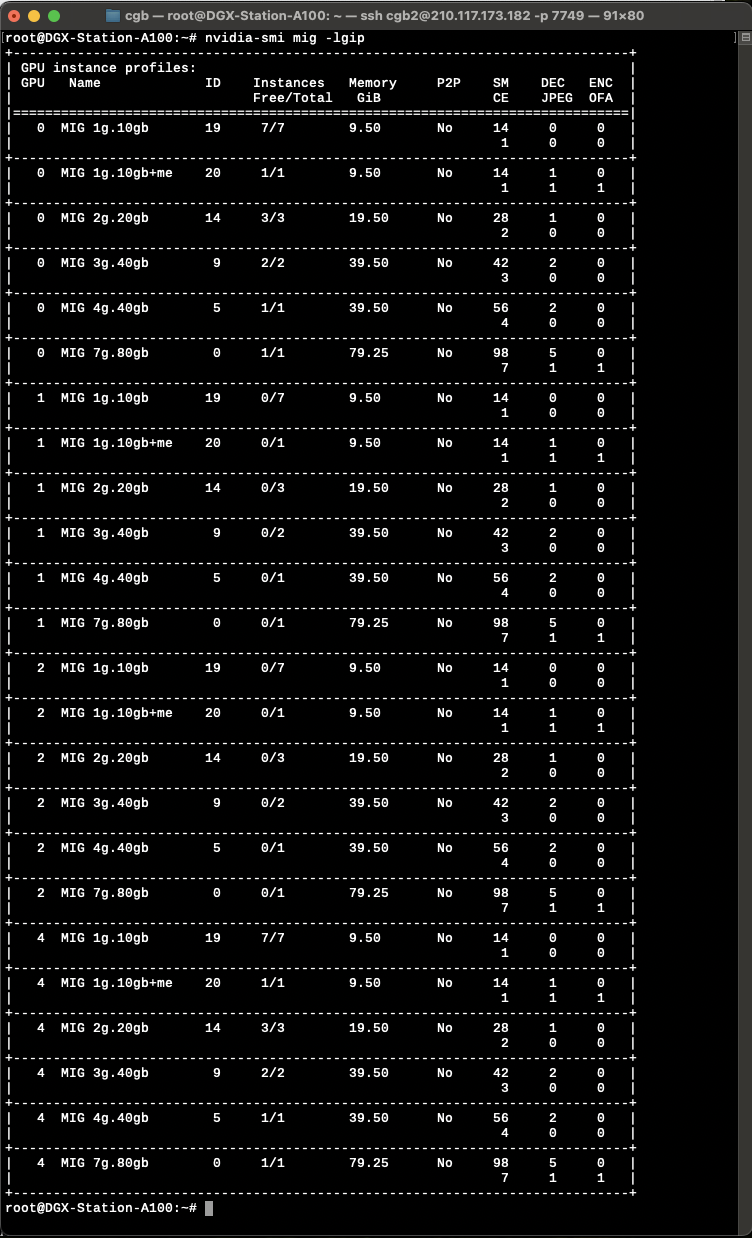

`-` 생성가능한 ci 확인 

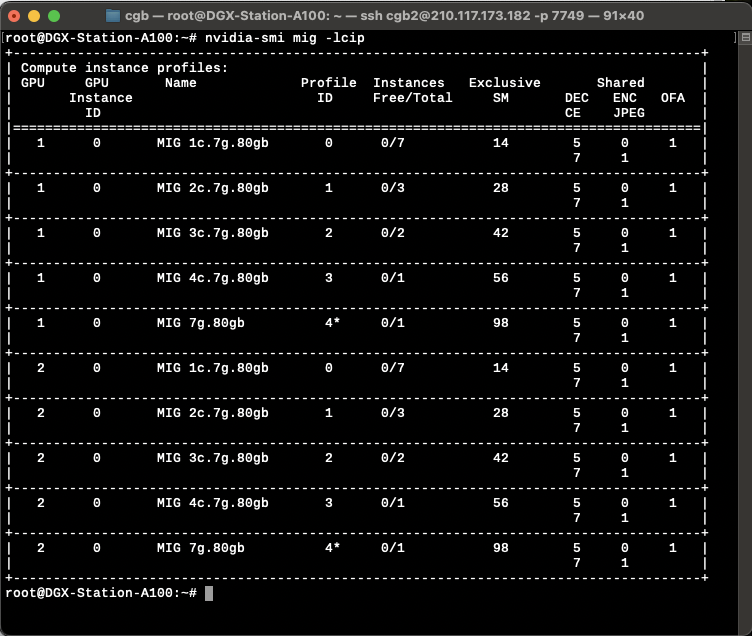

## C. GI 생성 

`-` `GPUdev` = 4 에서 생성가능한 `GI` 조회 

```bash
#nvidia-smi mig -i {GPUdev-ID} -lgip
nvidia-smi mig -i 4 -lgip
```

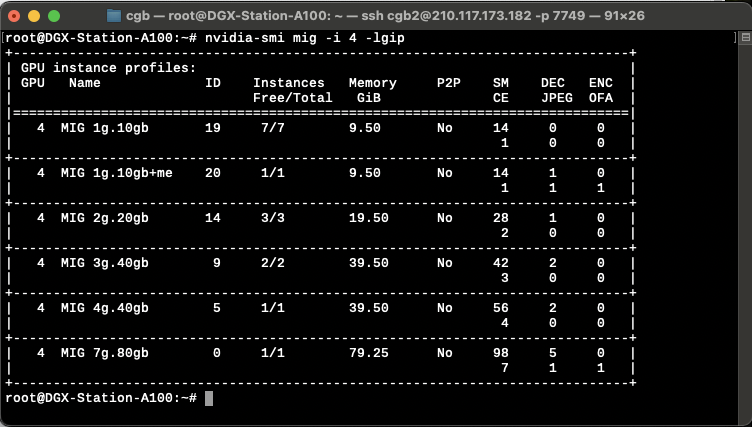

`-` 아래에 해당하는 `GI`를 2개 생성하고 싶다고 하자. (`GPU-INSTANCE-PROFILE-ID`=9 임을 유의)
```
+-----------------------------------------------------------------------------+
| GPU instance profiles:                                                      |
| GPU   Name             ID    Instances   Memory     P2P    SM    DEC   ENC  |
|                              Free/Total   GiB              CE    JPEG  OFA  |
|=============================================================================|
|   4  MIG 3g.40gb        9     0/2        39.50      No     42     2     0   |
|                                                             3     0     0   |
+-----------------------------------------------------------------------------+
```

```bash
#nvidia-smi mig -i {GPUdev-ID} -cgi {GPU-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -cgi 9 
nvidia-smi mig -i 4 -cgi 9 
```

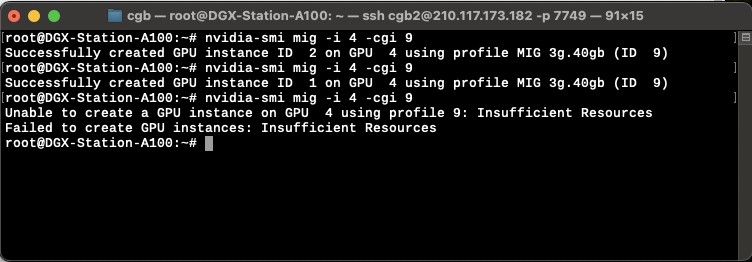

> 2개까지는 잘 만들어지고 그 이후에는 리소스부족으로 에러발생 

`-` 만들어진 `GI` 확인 

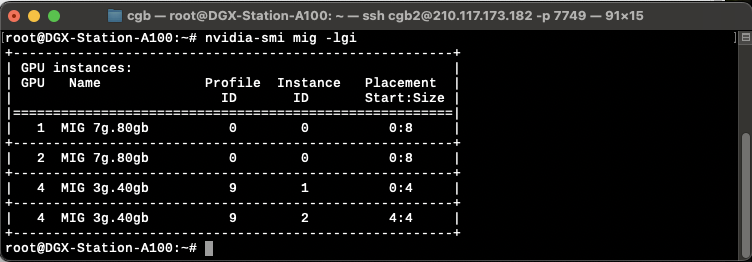

`-` 생성가능한 `CI` 확인 

```bash
nvidia-smi mig -lcip
```

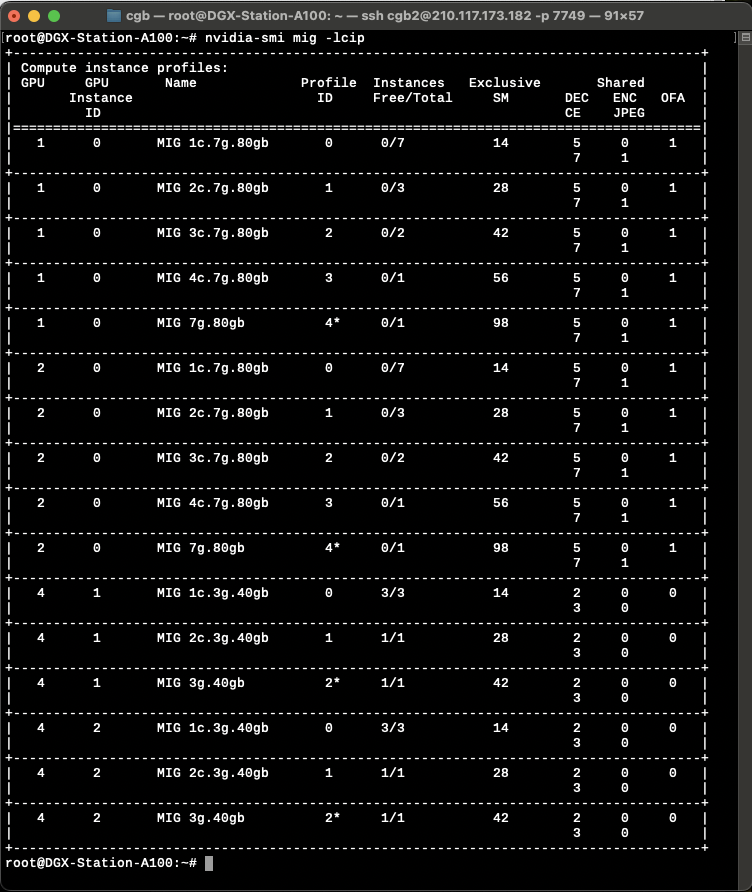

## D. CI 생성 

`-` `GPUdev`=4 에서 생성가능한 `CI` 조회 

```bash
#nvidia-smi mig -i {GPU ID} -lcip
nvidia-smi mig -i 4 -lcip
```

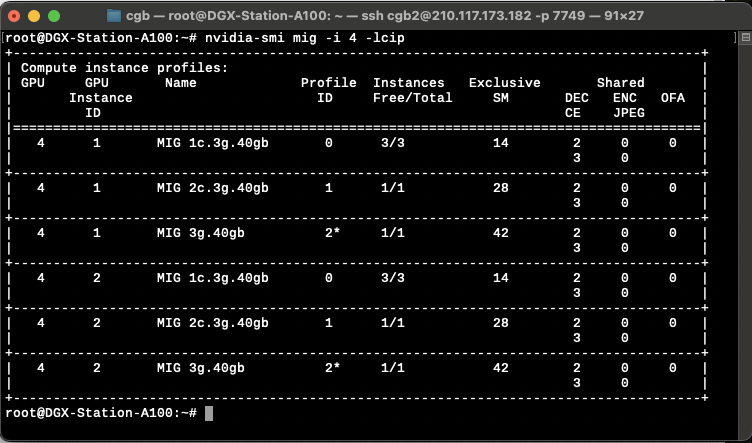

`-` {`GPUdev-ID`:`GI-ID`} = {4:1} 에서 `COMPUTE-INSTANCE-PROFILE-ID`=0 에 해당하는 CI를 3개 생성 

```bash
#nvidia-smi mig -i {GPUdev-ID} -gi {GI-ID} -cci {COMPUTE-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -gi 1 -cci 0
```

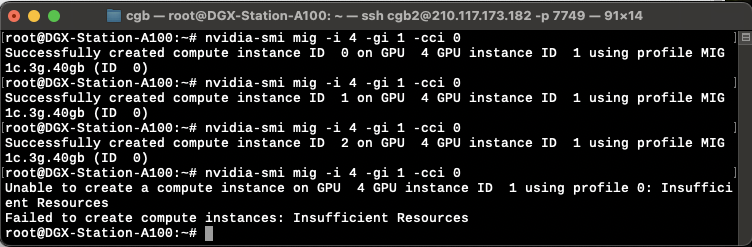

`-` {`GPUdev-ID`:`GI-ID`}={4:2} 에서 `COMPUTE-INSTANCE-PROFILE-ID`=2 에 해당하는 CI를 1개 생성 

```bash
#nvidia-smi mig -i {GPUdev-ID} -gi {GI-ID} -cci {COMPUTE-INSTANCE-PROFILE-ID}
nvidia-smi mig -i 4 -gi 2 -cci 2 
```

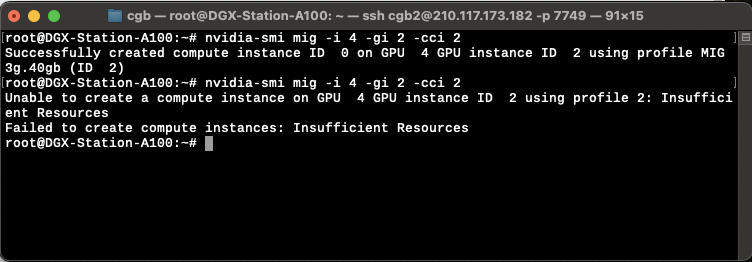

`-` 현재 상황 

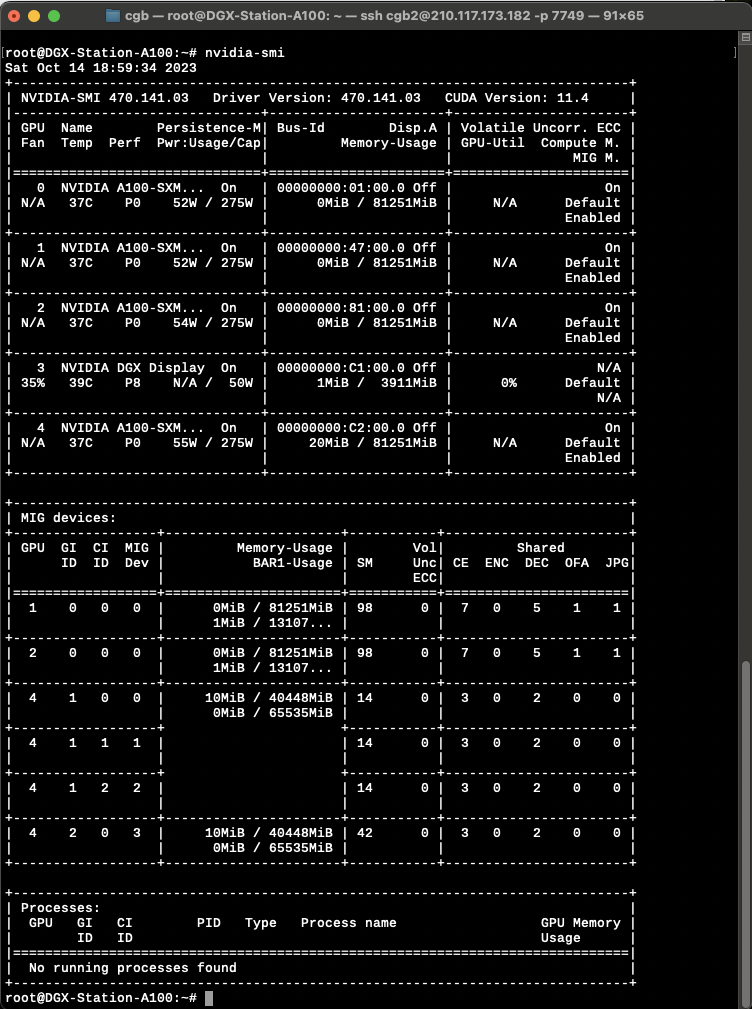

| GPUdev ID | GI ID      | CI ID     | MIGdev ID |
|--------|------------|-----------|-----------|
|   1    |  0 (80G)   |  0 (98SM) |     0     |
|   2    |  0 (80G)   |  0 (98SM) |     0     |
|   4    |  1 (80G)   |  0 (14SM) |     0     |
|   4    |  1 (80G)   |  1 (14SM) |     1     |
|   4    |  1 (80G)   |  2 (14SM) |     2     |
|   4    |  2 (80G)   |  0 (42SM) |     3     |

## E. 요약 

``` bash
nvidia-smi mig -i 0 -cgi 0   
nvidia-smi mig -i 1 -cgi 0   
nvidia-smi mig -i 2 -cgi 0   
nvidia-smi mig -i 4 -cgi 0   
nvidia-smi mig -i 0 -gi 0 -cci 4
nvidia-smi mig -i 1 -gi 0 -cci 4
nvidia-smi mig -i 2 -gi 0 -cci 4
nvidia-smi mig -i 4 -gi 0 -cci 4
```

# 2. DOCKER

## A. 컨테이너 생성 

`-` 아래와 같은 방식으로 컨테이너 생성 

```bash
# nvidia-docker run --gpus '"device={GPUdev-ID}:{MIGdev-ID}"' -ti --rm -d -t -p {HOST-PORT}:{CONTAINER-PORT} {DOCKER-IMAGE-NAME} /bin/bash
nvidia-docker run --gpus '"device=1:0"' -ti --rm -d -t -p 7749:7749  -p 1307:1307 ubuntu /bin/bash
nvidia-docker run --gpus '"device=2:0"' -ti -d -t -p 4653:4653  -p 1212:1212 -p 1213:1213 -p 1214:1214 ubuntu /bin/bash
```

- `-ti`: 컨테이너를 대화형(interactive) 모드로 실행. 이 모드에서 컨테이너와 상호작용할 수 있음.
- `--rm`: 컨테이너가 종료되면 자동으로 컨테이너를 삭제. 이 옵션을 사용하면 컨테이너를 실행한 후 자동으로 정리.
- `-d`: 컨테이너를 백그라운드(background) 모드로 실행. 이 옵션을 사용하면 컨테이너가 백그라운드에서 실행되며 터미널이 차지되지 않음.
- `-t`: 컨테이너에 tty (터미널)를 할당. 이것은 대화형 모드와 함께 사용.
- `/bin/bash`: 컨테이너가 시작될 때 실행할 명령어. 이 경우, Bash 셸을 실행.



## B. 컨테이너 실행 

```bash
docker exec -ti {CONTAINER-ID} bash
```


> 여기에서 `{CONTAINER-ID}`는 `docker ps` 혹은 `docker ps -a`로 확인한다. 

## C. 요약 

```bash
nvidia-docker run --gpus '"device=2:0"' -ti -d -t -p ????:???? -p ????:???? -p ????:???? -p ????:???? -p ????:???? --name cgb ubuntu /bin/bash
docker exec -ti cgb bash 
```

# 3. UBUNTU 

## A. `passwd` 

`-` 아래를 실행하여 비밀번호를 바꿀것 

```bash
passwd root
```

## B. update \& 쓸만한 패키지 설치

`-` update 

```bash 
apt update 
apt install gcc
apt install build-essential
```

`-` 쓸만한 패키지 설치 

```bash
apt install vim # vim 
apt install openssh-server # ssh 
apt install git # git 
apt install tmux
```

`-` 요약 

```bash
apt update && apt install -y gcc build-essential vim openssh-server git tmux
```

## D. `ssh` 설정

`-` `/etc/ssh/sshd_config` 열기 

```bash
# apt install openssh-server
vi /etc/ssh/sshd_config 
```

`-` `/etc/ssh/sshd_config` 파일내용 맨아래 아래를 추가 

```default

...
...
Port {My-SSH-Port}
PermitRootLogin yes
PasswordAuthentication yes
```

`-` 아래를 실행 

```bash 
service ssh restart
```

## E. anaconda

`-` 다운로드: <https://www.anaconda.com/download>

`-` (아나콘다 설치) 아나콘다를 다운받은 폴더로 가서 아래와 같이 실행한다. 

```bash
bash Anaconda3-2019.03-Linux-x86_64.sh
```

대충 `bash Ana` 정도까지만 치고 `tab`을 누르면 알아서 완성된다. 


## F. vscode 

`-` 아래를 이용하여 설치 

```bash
curl -Lk 'https://code.visualstudio.com/sha/download?build=stable&os=cli-alpine-x64' --output vscode_cli.tar.gz
tar -xf vscode_cli.tar.gz
```

`-` 아래를 이용하여 초기 설정 (깃헙아이디로 인증)

```bash
./code tunnel 
```

`-` 초기설정 이후 아래를 이용하여 백그라운드에서 실행 

```bash
nohup ./code tunnel > /dev/null 2>&1 &
```

## G. Jupyter 

`-` 설정파일 생성 

```bash
jupyter notebook --generate-config
```

`-` 패스워드 설정 

```bash
jupyter notebook password
## 패스워드 치고
## 확인해야함
```

`-` 설정파일을 열고

```bash
vi /home/cgb2/.jupyter/jupyter_notebook_config.py
```

아래의 내용을 수정한다.

```default
c.??????App.ip = '0.0.0.0'
c.??????App.port = 1307
c.??????App.allow_origin = '*'
c.??????App.allow_remote_access = True
c.??????App.allow_root = True
```

`-` 주피터 실행할때 아래로 실행 

```bash
nohup jupyter lab --ip="0.0.0.0" --port={MY-PORT} --no-browser --allow-root > /dev/null 2>&1 &
```